## Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [6]:
data_dir = './Dataset'

transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dsets = {x: dset.ImageFolder(os.path.join(data_dir, x), transform=transform)
         for x in ['train', 'val', 'test']}

train_dataset = dset.ImageFolder('./Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('./Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('./Dataset/test', transform=transform)

In [7]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating VGG model

In [6]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
for param in model.parameters():
    param.requires_grad = False
model.classifier._modules['6'] = nn.Linear(4096, 172)
# model.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [8]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=172, bias=True)
)


In [9]:
model = gpu(model)

## Training fully connected module

In [10]:
def load_array(fname):
    return bcolz.open(fname)[:]

### Loading Preconvoluted features

In [11]:
conv_feat_val = load_array('./vgg16/feat_val.bc')
labels_val = load_array('./vgg16/labels_val.bc')

In [12]:
print(len(conv_feat_val))
print(conv_feat_val.shape)

11016
(11016, 512, 7, 7)


In [13]:
optimizer = optim.Adam(model.parameters())

### Creating Data generator

In [14]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [15]:
def data_gen_train():
    for i in range(0, 11):
        conv_feat = load_array('./vgg16/feat_train_{}.bc'.format(i))
        labels = load_array('./vgg16/labels_train_{}.bc'.format(i))
        yield from data_gen(conv_feat, labels)

### Training the model

In [16]:
def train_model(model, optimizer, conv_feat_val, labels_val, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = data_gen_train()
        num_correct, num_samples, total_loss = 0, 0, 0
        for x, y in batches:
            x, y = gpu(torch.from_numpy(x)), gpu(torch.from_numpy(y))
            x = x.view(x.size(0), -1)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, conv_feat_val, labels_val, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, conv_feat_val, labels_val, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = data_gen(conv_feat=conv_feat_val, labels=labels_val)
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(torch.from_numpy(x)), gpu(torch.from_numpy(y))                
            x = x.view(x.size(0), -1)
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [17]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model.classifier), optimizer, conv_feat_val, labels_val, epochs=50)

Epoch: 1 Training Loss: 0.0398 Got 26534 / 66071 correct. Acc: 40.16%
Epoch: 1 Validation Loss: 0.0284 Got 5874 / 11016 correct 53.32%
Epoch: 2 Training Loss: 0.0343 Got 31159 / 66071 correct. Acc: 47.16%
Epoch: 2 Validation Loss: 0.0273 Got 6145 / 11016 correct 55.78%
Epoch: 3 Training Loss: 0.0331 Got 32605 / 66071 correct. Acc: 49.35%
Epoch: 3 Validation Loss: 0.0266 Got 6276 / 11016 correct 56.97%
Epoch: 4 Training Loss: 0.0328 Got 33263 / 66071 correct. Acc: 50.34%
Epoch: 4 Validation Loss: 0.0267 Got 6350 / 11016 correct 57.64%
Epoch: 5 Training Loss: 0.0324 Got 34066 / 66071 correct. Acc: 51.56%
Epoch: 5 Validation Loss: 0.0268 Got 6300 / 11016 correct 57.19%
Epoch: 6 Training Loss: 0.0321 Got 34418 / 66071 correct. Acc: 52.09%
Epoch: 6 Validation Loss: 0.0266 Got 6352 / 11016 correct 57.66%
Epoch: 7 Training Loss: 0.0322 Got 34491 / 66071 correct. Acc: 52.20%
Epoch: 7 Validation Loss: 0.0264 Got 6443 / 11016 correct 58.49%
Epoch: 8 Training Loss: 0.0320 Got 34889 / 66071 correc

In [ ]:
# Save the model.
PATH = "./vgg16/vgg16.dat"
torch.save(model, PATH)

## Evaluation

In [10]:
# Load the model.
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
compute_accuracy(loaded_model)

Top 1 Accuracy of the network on the all test images: 59 %


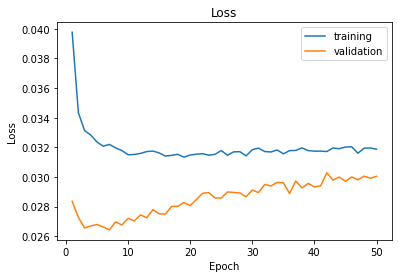

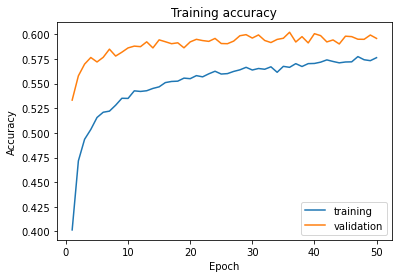

In [19]:
# Loss and Accuracy Curves

plt.figure()
E = np.arange(50)+1
plt.plot(E,LOSS,label='training')
plt.plot(E,LOSS_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(E,ACC,label='training')
plt.plot(E,ACC_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()
plt.show()

In [11]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %d %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

Top 1 Accuracy of the network on the all test images: 59 %


In [23]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %d %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 84 %


In [12]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [18]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())

In [51]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)

Confusion Matrix

<class 'numpy.ndarray'>


<AxesSubplot:>

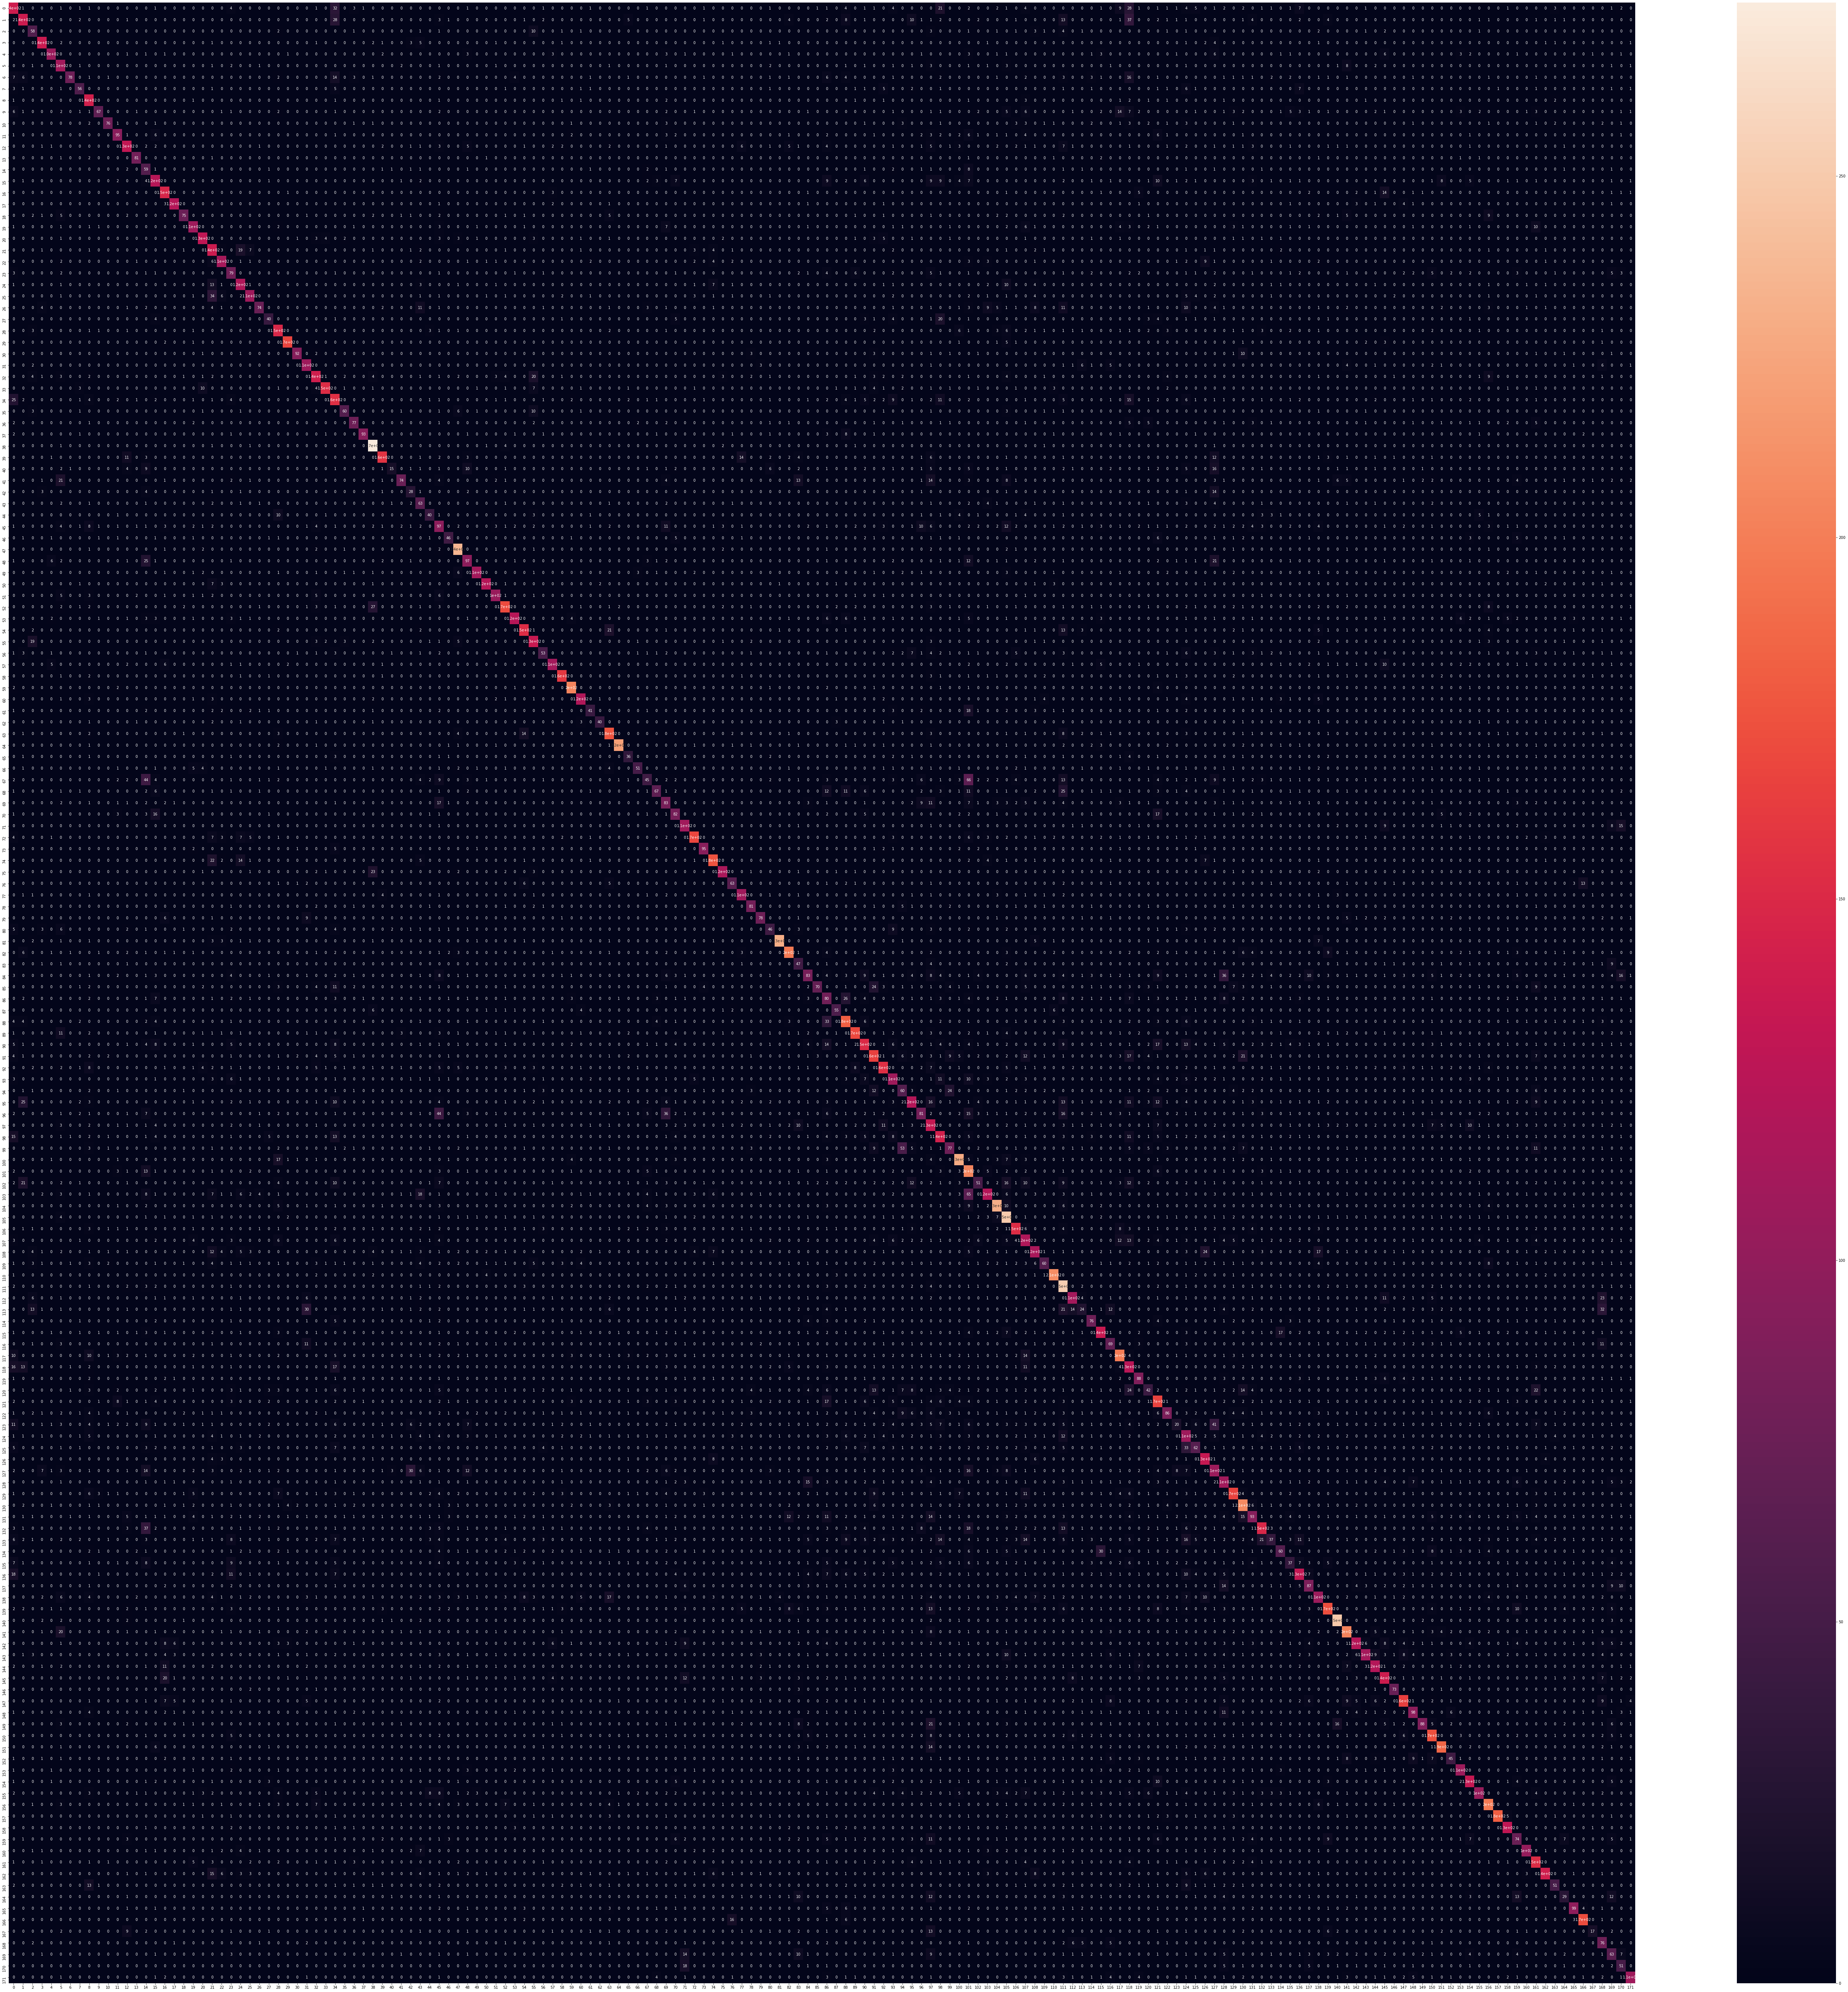

In [61]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

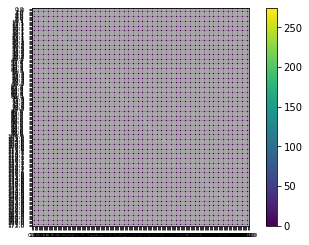

In [60]:
import numpy as np
import matplotlib.pyplot as plt

confmat=cnf_matrix
ticks=np.linspace(0, 172,num=172)
plt.imshow(confmat, interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [47]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = 'VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=food_names))


Accuracy: 0.59

Micro Precision: 0.59
Micro Recall: 0.59
Micro F1-score: 0.59

Macro Precision: 0.63
Macro Recall: 0.59
Macro F1-score: 0.59

Weighted Precision: 0.62
Weighted Recall: 0.59
Weighted F1-score: 0.59

Classification Report

                                              precision    recall  f1-score   support

                                Braised Pork       0.39      0.45      0.42       307
                          Sautéed Spicy Pork       0.56      0.48      0.52       287
             Cripsy sweet & sour pork slices       0.42      0.59      0.49        98
               Steamed pork with rice powder       0.76      0.81      0.79       168
                  Pork with salted vegetable       0.80      0.67      0.73       156
                   Shredded Pork with pepper       0.40      0.73      0.52       152
                     Yu-Shiang Shredded Pork       0.92      0.44      0.59       178
  Sautéed Sliced Pork, Eggs and Black Fungus       0.64      0.54      0.